# Quickstart Guide to Pytorch
This section runs through the API for common tasks in machine learning.\
Generally this section is for someone who is familir with other deep learning frameworks.

## Working with Data
PyTorch has two primitives to work with data: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this tutorial, we will be using a TorchVision dataset.

The `torchvision.datasets` module contains `Dataset` objects for many real-world vision data like CIFAR, COCO. In this tutorial, we use the FashionMNIST dataset. Every TorchVision `Dataset` includes two arguments: `transform` and `target_transform` to modify the samples and labels respectively.

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the `Dataset` as an argument to `DataLoader`. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")

    # Time to introspect further
    print(f"dtype of X: {X.dtype}") # Tells us the type of data in the input data
    print(f"The min and max values in X respectively: {X.min()}, {X.max()}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
dtype of X: torch.float32
The min and max values in X respectively: 0.0, 1.0


Furthermore I felt like extracting and looking at a single image so here is what I did

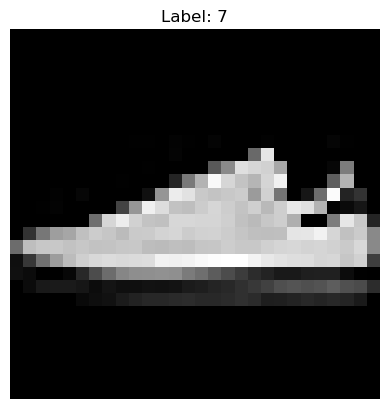

In [4]:
import matplotlib.pyplot as plt
# import numpy as np

single_image, single_label = training_data[6]
single_image = single_image.squeeze().numpy() # Remove the batch dimension and convert to NumPy
# single_image = (single_image * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8

plt.imshow(single_image, cmap='gray')
plt.title(f"Label: {single_label}")
plt.axis('off')  # Hide the axes
plt.show()
# plt.imsave('example.jpg', single_image, cmap='gray')

We can also inspect multiple images, for example create a grid of a batch in the input data

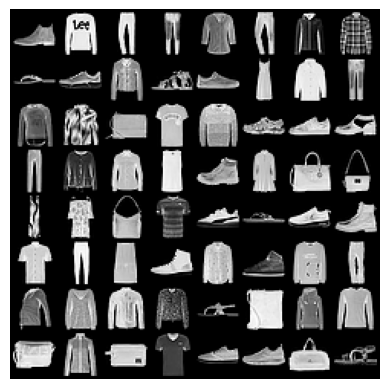

In [5]:
import torchvision.utils as vutils

# Create a grid of images
grid = vutils.make_grid(X, nrow=8, normalize=True, scale_each=True)

# Convert the grid to a NumPy array and permute dimensions
grid = grid.permute(1, 2, 0).numpy()

# Display the grid
plt.imshow(grid)
plt.axis('off')
plt.show()

## Creating Models
To define a neural network in PyTorch, we create a class that inherits from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network in the `__init__` function and specify how data will pass through the network in the `forward` function. To accelerate operations in the neural network, we move it to the [accelerator](https://pytorch.org/docs/stable/torch.html#accelerators) such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

EDIT: The above information regarding accelerators seems outdated as `torch.accelerator` only supports [CUDA](https://pytorch.org/docs/stable/cuda.html), [MTIA](https://pytorch.org/docs/stable/mtia.html), [XPU](https://pytorch.org/docs/stable/xpu.html).\
For mac systems we will instead directly check [MPS](https://pytorch.org/docs/stable/mps.html) availability or use cpu instead.

In [6]:
# For CUDA, MTIA, or XPU
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else torch.device("cpu")
# print(f"Using {device} device")

# For MPS (Mac systems)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using {device} device")

Using mps device


In [7]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)
print(f"Model is on device: {next(model.parameters()).device}")  # Should print 'mps'

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Model is on device: mps:0


## Optimising the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) and and [optimiser](https://pytorch.org/docs/stable/optim.html).

In [8]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model’s performance against the test dataset to ensure it is learning.

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.

In [11]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.311492  [   64/60000]
loss: 2.293662  [ 6464/60000]
loss: 2.278553  [12864/60000]
loss: 2.269704  [19264/60000]
loss: 2.252427  [25664/60000]
loss: 2.227463  [32064/60000]
loss: 2.240565  [38464/60000]
loss: 2.201384  [44864/60000]
loss: 2.198047  [51264/60000]
loss: 2.173079  [57664/60000]
Test Error: 
 Accuracy: 50.9%, Avg loss: 2.166078 

Epoch 2
-------------------------------
loss: 2.174698  [   64/60000]
loss: 2.158323  [ 6464/60000]
loss: 2.109015  [12864/60000]
loss: 2.128747  [19264/60000]
loss: 2.073018  [25664/60000]
loss: 2.021720  [32064/60000]
loss: 2.061239  [38464/60000]
loss: 1.972798  [44864/60000]
loss: 1.973918  [51264/60000]
loss: 1.918002  [57664/60000]
Test Error: 
 Accuracy: 54.5%, Avg loss: 1.907859 

Epoch 3
-------------------------------
loss: 1.933078  [   64/60000]
loss: 1.898628  [ 6464/60000]
loss: 1.790941  [12864/60000]
loss: 1.838273  [19264/60000]
loss: 1.721255  [25664/60000]
loss: 1.676981  [32064/600

More info on [training your model](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html).

## Saving Models
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

In [12]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models
The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [13]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

This model can now be used to make predictions.

In [14]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


More info on [saving and loading your model](https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html).